In [1]:
import os
import pandas as pd
import uproot
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import seaborn as sns


/eos/home-s/sraj/Work_/CUA_20--/Analysis/hhbbgg_AwkwardAnalyzer/bdt/notebook


In [18]:

# File paths
signal_files_lowX_lowY = [
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X650_Y60/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X650_Y70/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X650_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X650_Y/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X700_Y60/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X700_Y70/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X700_Y80/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_NMSSMv2-trees.root", "/NMSSM_X700_Y90/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y80/preselection"),
#     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y90/preselection"),
# #     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y95/preselection"),
# #     ("../../outputfiles/hhbbgg_analyzerNMSSM-trees.root", "/NMSSM_X550_Y100/preselection"),
]

background_files = [
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/GGJets/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/GJetPt20to40/preselection"),
    ("../../outputfiles/hhbbgg_analyzer_v2-trees.root", "/GJetPt40/preselection"),
]

In [19]:
# Columns to be loaded
keys = [
     'dibjet_pt', 'diphoton_pt', 'bbgg_pt', 'bbgg_eta', 'bbgg_phi',
    'lead_pho_phi', 'sublead_pho_eta', 'sublead_pho_phi', 'diphoton_eta', 
    'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 'lead_bjet_pt', 'sublead_bjet_pt', 
    'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 'sublead_bjet_phi', 
    'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 'CosThetaStar_jj', 
    'CosThetaStar_CS', 'DeltaR_jg_min',   'pholead_PtOverM', 'phosublead_PtOverM',
    'weight_preselection',
]
# Variables removed :- 'bbgg_mass','FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass', 'lead_pho_eta',

## Add 

In [20]:
# Load DataFrames
dfs = {}

# Load signal files
for file, key in signal_files_lowX_lowY:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Load background files
for file, key in background_files:
    try:
        with uproot.open(file) as f:
            dfs[key] = f[key].arrays(keys, library="pd")
    except Exception as e:
        print(f"Error loading {file} with key {key}: {e}")

# Combine signal DataFrames
signal_df = pd.concat([dfs[key] for key in dfs if 'NMSSM' in key], ignore_index=True)
background_df = pd.concat([dfs[key] for key in dfs if 'GJet' in key or 'GGJets' in key], ignore_index=True)



# signal_df = pd.concat([])
# Print combined sample sizes
print(f'Total Signal Shape: {signal_df.shape}')
print(f'Total Background Shape: {background_df.shape}')


Total Signal Shape: (169493, 27)
Total Background Shape: (245708, 27)


In [23]:
# Assign labels to signal and background classes
signal_df['label'] = 0  # Signal class

# Assign background labels based on the key
dfs["/GGJets/preselection"]['label'] = 1  # Background class 1
dfs["/GJetPt20to40/preselection"]['label'] = 2  # Background class 2
dfs["/GJetPt40/preselection"]['label'] = 2  # Background class 2

# Combine signal and all background dataframes into one DataFrame
combined_df = pd.concat([signal_df, dfs["/GGJets/preselection"], dfs["/GJetPt20to40/preselection"], dfs["/GJetPt40/preselection"]], ignore_index=True)


In [24]:
# # Combine signal and background data
# combined_df = pd.concat([signal_df, background_df], ignore_index=True)
# print(f'Combined DataFrame Shape: {combined_df.shape}')

# Define features and labels
features = [
    'bbgg_eta', 'bbgg_phi', 'lead_pho_phi', 'sublead_pho_eta', 
    'sublead_pho_phi', 'diphoton_eta', 'diphoton_phi', 'dibjet_eta', 'dibjet_phi', 
    'lead_bjet_pt', 'sublead_bjet_pt', 'lead_bjet_eta', 'lead_bjet_phi', 'sublead_bjet_eta', 
    'sublead_bjet_phi', 'sublead_bjet_PNetB', 'lead_bjet_PNetB', 'CosThetaStar_gg', 
    'CosThetaStar_jj', 'CosThetaStar_CS', 'DeltaR_jg_min', 'pholead_PtOverM', 
    'phosublead_PtOverM'
]

# variables removed:  'bbgg_mass',  'lead_pho_eta','FirstJet_PtOverM', 'SecondJet_PtOverM', 'diphoton_bbgg_mass', 'dibjet_bbgg_mass'

In [25]:

X = combined_df[features]
y = combined_df['label']
weights = combined_df['weight_preselection']

# Impute missing values and scale the data
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Extract weights for train and test datasets
X_train_weights = combined_df.loc[X_train.index, 'weight_preselection']
X_test_weights = combined_df.loc[X_test.index, 'weight_preselection']

# Impute and scale the features
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [26]:
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Convert data to torch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
X_train_weights_tensor = torch.tensor(X_train_weights.values, dtype=torch.float32)
X_test_weights_tensor = torch.tensor(X_test_weights.values, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor, X_train_weights_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor, X_test_weights_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)



In [27]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available.
Device name: Tesla T4


## Multiclassification 

In [28]:
class SimpleDNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, output_dim)  # Adjust output_dim based on number of classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Softmax activation for multi-class classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.output(x))  # Use softmax activation in the output
        return x


In [29]:
criterion = nn.CrossEntropyLoss()


y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Multiclass prediction
    correct = (preds == labels).float().sum()  # Count correct predictions
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy


In [30]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np

# Define your DNN model for multiclass classification
class SimpleDNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, num_classes)  # Output layer for num_classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Apply Softmax for multiclass classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.output(x))  # Output probabilities
        return x

# Function to calculate accuracy for multiclass classification
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()  # Compare with true labels
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy

# Initialize the model
input_dim = X_train.shape[1]  # Assuming X_train is your training data
num_classes = 3  # Example number of classes
model = SimpleDNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass classification
optimizer = Adam(model.parameters(), lr=0.001)

In [13]:


# To store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for X_batch, y_batch, weight_batch in train_loader:  # Assuming train_loader is your DataLoader
        optimizer.zero_grad()
        
        # Cast y_batch to LongTensor
        y_batch = y_batch.long()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, y_batch).item()

    # Average training accuracy and loss
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for X_batch, y_batch, weight_batch in test_loader:  # Assuming test_loader is your DataLoader
            # Cast y_batch to LongTensor for test data
            y_batch = y_batch.long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_outputs.append(outputs.numpy())
            test_labels.append(y_batch.numpy())
    
    # Combine lists into numpy arrays for accuracy calculation
    test_outputs = np.concatenate(test_outputs)
    test_labels = np.concatenate(test_labels)
    
    # Calculate test accuracy
    test_accuracy = calculate_accuracy(torch.tensor(test_outputs), torch.tensor(test_labels)).item()

    # Append test losses and accuracies
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)
    
    # Save the model after training
    torch.save(model.state_dict(), 'modelFile/simple_dnn_model.pth')


    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch 1/50, Train Loss: 4225.6672, Train Accuracy: 0.8204
Epoch 1/50, Test Loss: 1027.8308, Test Accuracy: 0.8418
Epoch 2/50, Train Loss: 4139.8226, Train Accuracy: 0.8370
Epoch 2/50, Test Loss: 1025.4494, Test Accuracy: 0.8439
Epoch 3/50, Train Loss: 4120.6146, Train Accuracy: 0.8406
Epoch 3/50, Test Loss: 1022.5820, Test Accuracy: 0.8465
Epoch 4/50, Train Loss: 4108.7882, Train Accuracy: 0.8431
Epoch 4/50, Test Loss: 1018.9356, Test Accuracy: 0.8477
Epoch 5/50, Train Loss: 4099.9465, Train Accuracy: 0.8441
Epoch 5/50, Test Loss: 1017.2997, Test Accuracy: 0.8489
Epoch 6/50, Train Loss: 4096.3984, Train Accuracy: 0.8451
Epoch 6/50, Test Loss: 1017.5956, Test Accuracy: 0.8496
Epoch 7/50, Train Loss: 4093.9558, Train Accuracy: 0.8451
Epoch 7/50, Test Loss: 1019.2933, Test Accuracy: 0.8477
Epoch 8/50, Train Loss: 4090.2336, Train Accuracy: 0.8462
Epoch 8/50, Test Loss: 1018.7927, Test Accuracy: 0.8493
Epoch 9/50, Train Loss: 4090.9958, Train Accuracy: 0.8462
Epoch 9/50, Test Loss: 1019.19

### model optimization

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define your DNN model for multiclass classification
class SimpleDNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, num_classes)  # Output layer for num_classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.output(x)  # Return logits (no Softmax)
        return x

# Function to calculate accuracy for multiclass classification
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()  # Compare with true labels
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy

# Initialize the model
input_dim = X_train.shape[1]  # Assuming X_train is your training data
num_classes = 3  # Example number of classes
model = SimpleDNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass classification
optimizer = Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, min_lr=1e-6)

# To store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Early stopping parameters
patience = 5  # How many epochs to wait before stopping
best_test_loss = float('inf')
patience_counter = 0

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for X_batch, y_batch, weight_batch in train_loader:  # Assuming train_loader is your DataLoader
        optimizer.zero_grad()

        # Cast y_batch to LongTensor
        y_batch = y_batch.long()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, y_batch).item()

    # Average training accuracy and loss
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for X_batch, y_batch, weight_batch in test_loader:  # Assuming test_loader is your DataLoader
            # Cast y_batch to LongTensor for test data
            y_batch = y_batch.long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, y_batch).item()
    
    # Average test accuracy and loss
    test_accuracy /= len(test_loader)
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Step the scheduler
    scheduler.step(test_loss)

    # Check for early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # Save the model after finding a better validation loss
        torch.save(model.state_dict(), 'modelFile/simple_dnn_model_best.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            break

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


In [ ]:
## Load the saved model
# Initialize the model
model = SimpleDNN(input_dim, num_classes)

# Load the saved model parameters
model.load_state_dict(torch.load('modelFile/simple_dnn_model.pth'))

# Set the model to evaluation mode
model.eval()

# Now you can use the model for inference or testing


In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

# Binarize the output for multiclass classification
num_classes = 3  # Example number of classes
y_train_bin = label_binarize(train_true, classes=[i for i in range(num_classes)])
y_test_bin = label_binarize(test_true, classes=[i for i in range(num_classes)])

# Compute ROC curve and ROC area for each class for training data
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(num_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], train_preds[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute ROC curve and ROC area for each class for test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], test_preds[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Plot ROC curves
def plot_roc_multiclass(fpr, tpr, roc_auc, title, num_classes):
    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure()
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

# Plot the ROC curves for training data
plot_roc_multiclass(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train Data)', num_classes)

# Plot the ROC curves for test data
plot_roc_multiclass(fpr_test, tpr_test, roc_auc_test, 'ROC Curve (Test Data)', num_classes)

plt.tight_layout()
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_ROC(after_variable_removal).png")
plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_ROC(after_variable_removal).pdf")
plt.show()

NameError: name 'train_true' is not defined

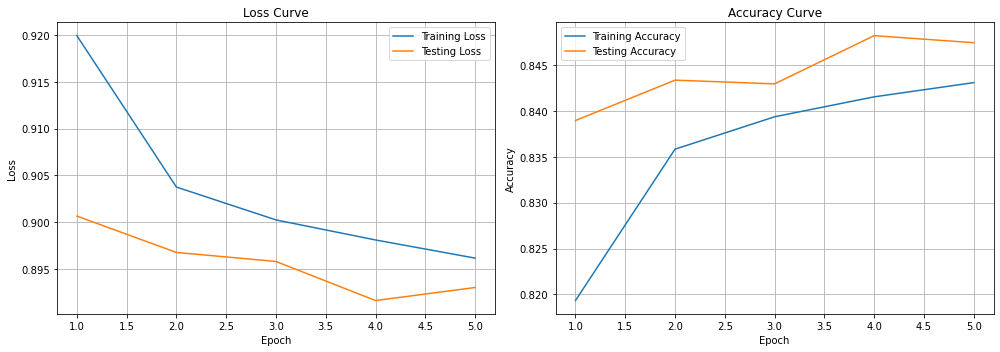

In [17]:
plt.figure(figsize=(14, 5))

# Plot Training and Testing Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

# Plot Training and Testing Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


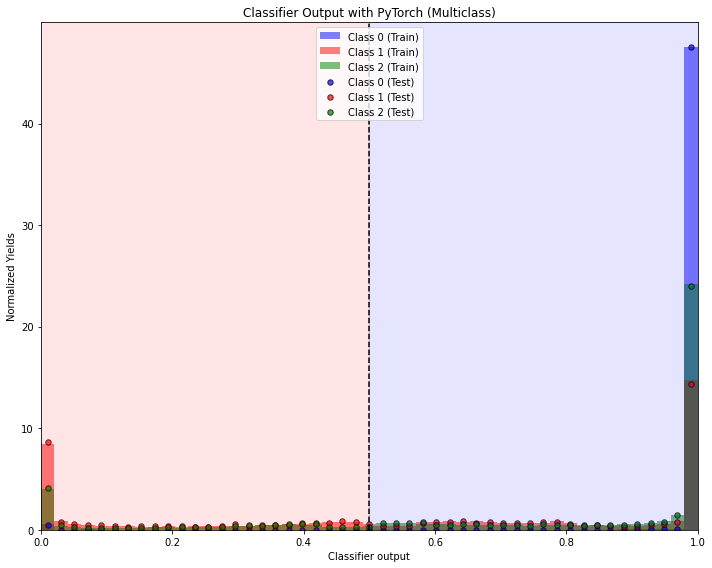

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming the get_predictions function is already defined
def get_predictions(loader, model):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels, _ in loader:
            outputs = model(inputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions for training and test data
train_preds, train_true = get_predictions(train_loader, model)
test_preds, test_true = get_predictions(test_loader, model)

# Define bins
bins = np.linspace(0, 1, 50)

plt.figure(figsize=(10, 8))

# Define distinct colors for each class
colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'orange',
    # Add more colors if you have more classes
}

# Plot histograms for training data for each class
for i in range(num_classes):
    color = colors.get(i, 'black')  # Fallback to black if class not found
    class_mask_train = (train_true == i)
    class_preds = train_preds[class_mask_train, i]  # Predictions for class i
    
    # Only plot if there are predictions for the class
    if len(class_preds) > 0:
        plt.hist(class_preds, bins=bins, color=color, alpha=0.5, 
                 label=f'Class {i} (Train)', density=True)

# Calculate bin centers for the scatter plot
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histograms for test data for each class
for i in range(num_classes):
    color = colors.get(i, 'black')  # Fallback to black if class not found
    class_mask_test = (test_true == i)
    class_preds_test = test_preds[class_mask_test, i]  # Predictions for class i
    
    # Only plot if there are predictions for the class
    if len(class_preds_test) > 0:
        hist_values, _ = np.histogram(class_preds_test, bins=bins, density=True)
        plt.scatter(bin_centers, hist_values, color=color, alpha=0.7, 
                    label=f'Class {i} (Test)', marker='o', s=30, edgecolor='k')

# Add background colors and legend
plt.axvspan(0, 0.5, color='red', alpha=0.1)
plt.axvspan(0.5, 1, color='blue', alpha=0.1)
plt.axvline(0.5, color='k', linestyle='--')

plt.xlabel('Classifier output')
plt.ylabel('Normalized Yields')
plt.xlim(0, 1)
plt.legend(loc='upper center')
plt.title('Classifier Output with PyTorch (Multiclass)')

# Save and display the plot
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_classifier_output(after_variable_removal).png")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_classifier_output(after_variable_removal).pdf")
plt.tight_layout()
plt.show()

#### Fixing 

In [31]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from scipy import interp

# Define your DNN model for multiclass classification
class SimpleDNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.3)
        self.output = nn.Linear(16, num_classes)  # Output layer for num_classes
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # Apply Softmax for multiclass classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.softmax(self.output(x))  # Output probabilities
        return x

# Function to calculate accuracy for multiclass classification
def calculate_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)  # Get the predicted class
    correct = (preds == labels).float().sum()  # Compare with true labels
    accuracy = correct / labels.size(0)  # Compute accuracy
    return accuracy

# Initialize the model
input_dim = X_train.shape[1]  # Assuming X_train is your training data
num_classes = 3  # Example number of classes
model = SimpleDNN(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss for multiclass classification
optimizer = Adam(model.parameters(), lr=0.001)

# To store losses and accuracies
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for X_batch, y_batch, weight_batch in train_loader:  # Assuming train_loader is your DataLoader
        optimizer.zero_grad()
        
        # Cast y_batch to LongTensor
        y_batch = y_batch.long()

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, y_batch).item()

    # Average training accuracy and loss
    train_accuracy /= len(train_loader)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for X_batch, y_batch, weight_batch in test_loader:  # Assuming test_loader is your DataLoader
            # Cast y_batch to LongTensor for test data
            y_batch = y_batch.long()

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            test_outputs.append(outputs.numpy())
            test_labels.append(y_batch.numpy())
    
    # Combine lists into numpy arrays for accuracy calculation
    test_outputs = np.concatenate(test_outputs)
    test_labels = np.concatenate(test_labels)
    
    # Calculate test accuracy
    test_accuracy = calculate_accuracy(torch.tensor(test_outputs), torch.tensor(test_labels)).item()

    # Append test losses and accuracies
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(test_accuracy)

    # Print epoch statistics
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Epoch {epoch + 1}/{epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Collect true labels and predictions for ROC curve calculation
train_true = []
train_preds = []
test_true = []
test_preds = []

# During training, collect predictions and true labels
for X_batch, y_batch, weight_batch in train_loader:
    y_batch = y_batch.long()
    outputs = model(X_batch)
    train_preds.append(outputs.detach().numpy())
    train_true.append(y_batch.numpy())

# During testing, collect predictions and true labels
with torch.no_grad():
    for X_batch, y_batch, weight_batch in test_loader:
        y_batch = y_batch.long()
        outputs = model(X_batch)
        test_preds.append(outputs.detach().numpy())
        test_true.append(y_batch.numpy())

# Convert lists to numpy arrays for binarization and ROC calculation
train_true = np.concatenate(train_true)
train_preds = np.concatenate(train_preds)
test_true = np.concatenate(test_true)
test_preds = np.concatenate(test_preds)

# Binarize the output for multiclass classification
y_train_bin = label_binarize(train_true, classes=[i for i in range(num_classes)])
y_test_bin = label_binarize(test_true, classes=[i for i in range(num_classes)])

# Compute ROC curve and ROC area for each class for training data
fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()
for i in range(num_classes):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_bin[:, i], train_preds[:, i])
    roc_auc_train[i] = auc(fpr_train[i], tpr_train[i])

# Compute ROC curve and ROC area for each class for test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(num_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], test_preds[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])




Epoch 1/50, Train Loss: 7109.0007, Train Accuracy: 0.8663
Epoch 1/50, Test Loss: 1769.7211, Test Accuracy: 0.8692
Epoch 2/50, Train Loss: 7068.4131, Train Accuracy: 0.8698
Epoch 2/50, Test Loss: 1765.8356, Test Accuracy: 0.8701
Epoch 3/50, Train Loss: 7060.8473, Train Accuracy: 0.8707
Epoch 3/50, Test Loss: 1764.1729, Test Accuracy: 0.8715
Epoch 4/50, Train Loss: 7055.9990, Train Accuracy: 0.8711
Epoch 4/50, Test Loss: 1762.5013, Test Accuracy: 0.8718
Epoch 5/50, Train Loss: 7049.0384, Train Accuracy: 0.8719
Epoch 5/50, Test Loss: 1761.8537, Test Accuracy: 0.8722
Epoch 6/50, Train Loss: 7046.6308, Train Accuracy: 0.8721
Epoch 6/50, Test Loss: 1760.3575, Test Accuracy: 0.8728
Epoch 7/50, Train Loss: 7044.0066, Train Accuracy: 0.8724
Epoch 7/50, Test Loss: 1760.2407, Test Accuracy: 0.8731
Epoch 8/50, Train Loss: 7043.1342, Train Accuracy: 0.8724
Epoch 8/50, Test Loss: 1759.7345, Test Accuracy: 0.8729
Epoch 9/50, Train Loss: 7039.3251, Train Accuracy: 0.8729
Epoch 9/50, Test Loss: 1758.97

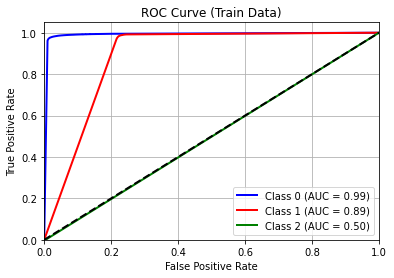

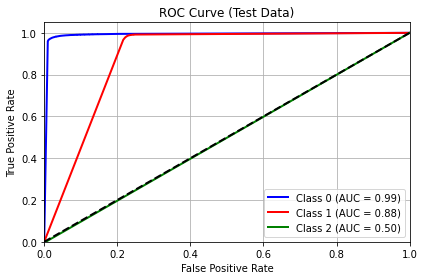

In [32]:
# Plot ROC curves
def plot_roc_multiclass(fpr, tpr, roc_auc, title, num_classes):
    colors = cycle(['blue', 'red', 'green', 'orange'])
    plt.figure()
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)

# Plot the ROC curves for training data
plot_roc_multiclass(fpr_train, tpr_train, roc_auc_train, 'ROC Curve (Train Data)', num_classes)

# Plot the ROC curves for test data
plot_roc_multiclass(fpr_test, tpr_test, roc_auc_test, 'ROC Curve (Test Data)', num_classes)

plt.tight_layout()
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_ROC(after_variable_removal).png")
# plt.savefig("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/plots_v1/NMSSM_signal/ML_plots/multiclass_ROC(after_variable_removal).pdf")
plt.show()

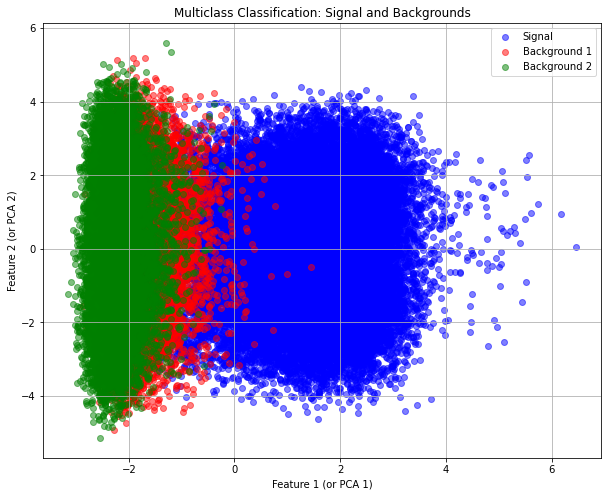

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA  # Optional, for dimensionality reduction

# Assuming you have already trained the model and you want to plot test data outputs

# Get predictions on test data
model.eval()
test_preds = []
test_labels = []
with torch.no_grad():
    for X_batch, y_batch, weight_batch in test_loader:
        outputs = model(X_batch)
        test_preds.append(torch.argmax(outputs, dim=1).numpy())  # Predicted classes
        test_labels.append(y_batch.numpy())  # True classes

# Combine batches into a single array
test_preds = np.concatenate(test_preds)
test_labels = np.concatenate(test_labels)

# If the input has more than two dimensions, apply PCA to reduce to 2D for visualization
if X_test_tensor.shape[1] > 2:
    pca = PCA(n_components=2)
    X_test_2d = pca.fit_transform(X_test_tensor.numpy())  # Reduce to 2D
else:
    X_test_2d = X_test_tensor.numpy()

# Plot the predictions: signal (0) and background classes (1, 2)
plt.figure(figsize=(10, 8))

# Signal class (0)
plt.scatter(X_test_2d[test_preds == 0, 0], X_test_2d[test_preds == 0, 1], 
            color='blue', label='Signal', alpha=0.5)

# Background class 1 (1)
plt.scatter(X_test_2d[test_preds == 1, 0], X_test_2d[test_preds == 1, 1], 
            color='red', label='Background 1', alpha=0.5)

# Background class 2 (2)
plt.scatter(X_test_2d[test_preds == 2, 0], X_test_2d[test_preds == 2, 1], 
            color='green', label='Background 2', alpha=0.5)

# Add plot labels and legend
plt.title('Multiclass Classification: Signal and Backgrounds')
plt.xlabel('Feature 1 (or PCA 1)')
plt.ylabel('Feature 2 (or PCA 2)')
plt.legend()
plt.grid(True)
plt.show()
